In [1]:
import pandas as pd

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from datetime import datetime

# Replace this to use Noisy QLSTM
# from QLSTM_Noisy import SequenceDataset
from QLSTM import SequenceDataset

import yfinance as yf

In [2]:
columns = ['Close', 'High', 'Low', 'Open']

#df = pd.read_csv('./AAPL_2022-01-01_2023-01-01.csv')
#data = df.filter(columns)

df = yf.download("AAPL", start="2022-01-01", end="2023-01-01", auto_adjust=False)
data = df.iloc[:, [1,2,3,4]] # [ ?, close, high, low, open, volume]

dataset = data.values

[*********************100%***********************]  1 of 1 completed


In [3]:
# Splitting the data into train and test
size = int(len(df) * 0.7)
df_train = dataset[:size].copy()
df_test = dataset[size:].copy()

In [4]:
# Select the features
df_train = pd.DataFrame(df_train, columns=columns)
df_test = pd.DataFrame(df_test, columns=columns)

features = df_train.columns
target = 'Close'
print(features)

Index(['Close', 'High', 'Low', 'Open'], dtype='object')


In [5]:
def normalize(a, min_a=None, max_a=None):
    if min_a is None:
        min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

In [6]:
# Normalizing the data
df_train, min_train, max_train = normalize(df_train)
df_test, _, _ = normalize(df_test, min_train, max_train)

In [7]:
torch.manual_seed(101)

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 4])
Target shape: torch.Size([1])


In [8]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss


def test_model(data_loader, model, loss_function): 
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [9]:
from QLSTM import QShallowRegressionLSTM

learning_rate = 0.01
num_hidden_units = 16

Qmodel = QShallowRegressionLSTM(
    num_sensors=len(features), 
    hidden_units=num_hidden_units, 
    n_qubits=7,
    n_qlayers=1
)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(Qmodel.parameters(), lr=learning_rate)

weight_shapes = (n_qlayers, n_vrotations, n_qubits) = (1, 3, 7)


In [10]:
# Count number of parameters
num_params = sum(p.numel() for p in Qmodel.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 292


In [11]:
quantum_loss_train = []
quantum_loss_test = []
print("Untrained test\n--------")
# start = time.time()
# test_loss = test_model(test_loader, Qmodel, loss_function)
# end = time.time()
# print("Execution time", end - start)
# quantum_loss_test.append(test_loss)

num_epochs = 50

for ix_epoch in range(num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, Qmodel, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, Qmodel, loss_function)
    end = time.time()
    print("Execution time", end - start)
    quantum_loss_train.append(train_loss)
    quantum_loss_test.append(test_loss)

Untrained test
--------
Epoch 0
---------
Train loss: 0.06714648725261546
Test loss: 0.004057028846851178
Execution time 102.69905996322632
Epoch 1
---------
Train loss: 0.0028419565074815573
Test loss: 0.0017082231823173132
Execution time 106.88483786582947
Epoch 2
---------
Train loss: 0.0019204358781873055
Test loss: 0.0008848664951579778
Execution time 111.80484104156494
Epoch 3
---------
Train loss: 0.0009866804653790545
Test loss: 0.0016387001229561879
Execution time 103.65666890144348
Epoch 4
---------
Train loss: 0.0011779591334022603
Test loss: 0.0003867481608098519
Execution time 102.12132096290588
Epoch 5
---------
Train loss: 0.0006878220346325545
Test loss: 0.000308806444870977
Execution time 102.48273277282715
Epoch 6
---------
Train loss: 0.0005374826892326975
Test loss: 0.0003471661113492759
Execution time 105.7789466381073
Epoch 7
---------
Train loss: 0.0005521698400483339
Test loss: 0.0007492492503967254
Execution time 119.55576181411743
Epoch 8
---------
Train loss:

In [12]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_eval_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model Forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, Qmodel).numpy()
df_test[ystar_col_Q] = predict(test_eval_loader, Qmodel).numpy()

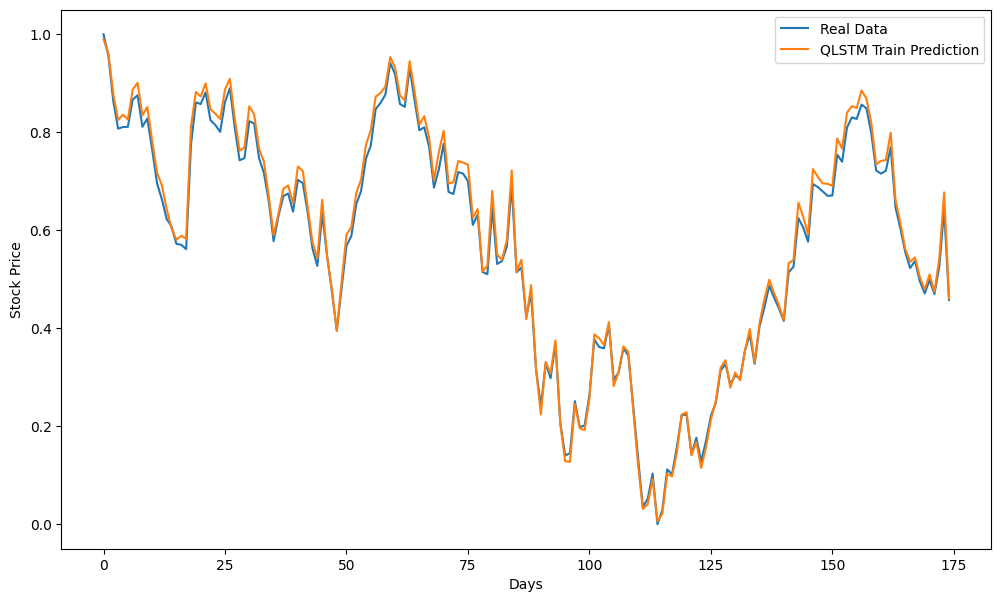

In [13]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_train)), df_train["Close"], label = "Real Data")
plt.plot(range(len(df_train)), df_train["Model Forecast"], label = "QLSTM Train Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.legend()
plt.show()

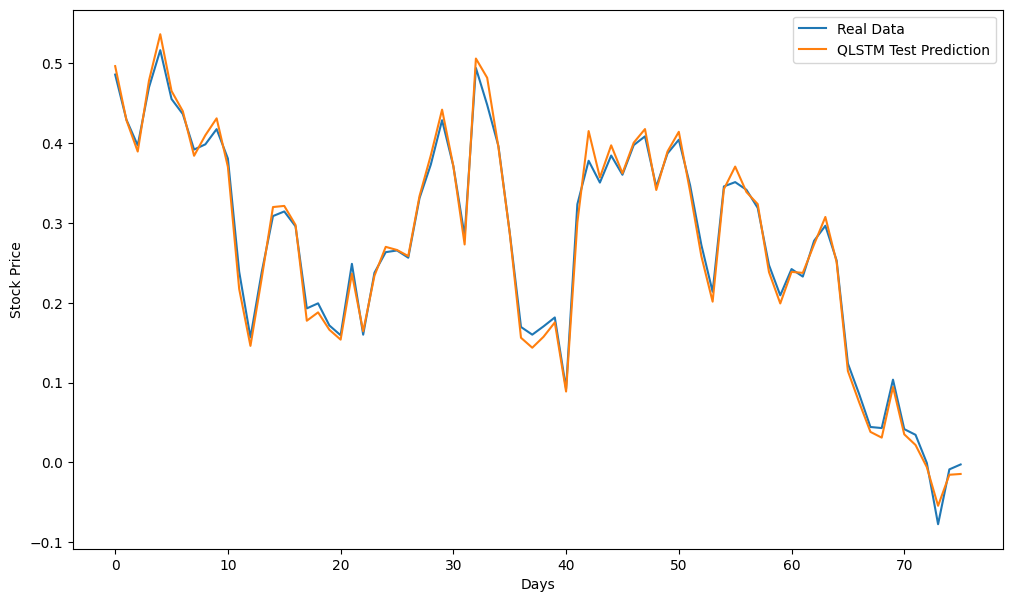

In [14]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_test)), df_test["Close"], label = "Real Data")
plt.plot(range(len(df_test)), df_test["Model Forecast"], label = "QLSTM Test Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.legend() 
plt.show()

In [15]:
def round_sigfig(x, sf):
    if x == 0:
        return 0
    magnitude = np.floor(np.log10(abs(x)))
    factor = 10 ** (sf - 1 - magnitude)
    return round(x * factor) / factor

In [16]:
# Calculate the RMSE for the train and test data
from sklearn.metrics import mean_squared_error

train_rmse = math.sqrt(mean_squared_error(df_train["Close"], df_train["Model Forecast"]))
test_rmse = math.sqrt(mean_squared_error(df_test["Close"], df_test["Model Forecast"]))
print(f"Train RMSE: {1000 * round_sigfig(train_rmse, 3)} * 10^3")
print(f"Test RMSE:  {1000 * round_sigfig(test_rmse, 3)} * 10^3")

Train RMSE: 17.6 * 10^3
Test RMSE:  11.5 * 10^3


In [17]:
# Calculate the accuracy of the model
def accuracy(y, y_star):
    return np.mean(np.abs(y - y_star) < 0.01)

train_accuracy = accuracy(df_train["Close"], df_train["Model Forecast"])
test_accuracy = accuracy(df_test["Close"], df_test["Model Forecast"])
print(f"Train accuracy: {round_sigfig(train_accuracy, 3)}")
print(f"Test accuracy:  {round_sigfig(test_accuracy, 3)}")

Train accuracy: 0.314
Test accuracy:  0.566


In [18]:
# Save the trained model
torch.save(Qmodel.state_dict(), "QLSTM_Stock_Price_Model.pt")

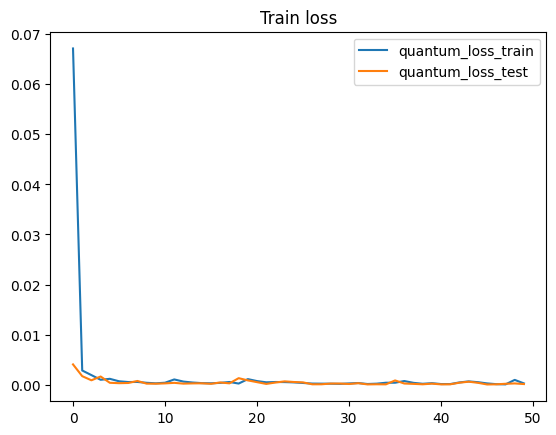

In [19]:
plt.plot(quantum_loss_train, label='quantum_loss_train')
plt.plot(quantum_loss_test, label='quantum_loss_test')
pd.DataFrame(quantum_loss_train).to_csv('QLSTM_loss.csv', index=False)
plt.title('Train loss')
plt.legend()